In [1]:
# Install & Import Libraries
import os
from datetime import datetime
import warnings

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

In [2]:
# Set Path Configs
ROOT_PATH = os.getcwd()
DATA_PATH = os.path.join(ROOT_PATH, 'data')
IMAGE_DATA_PATH = os.path.join(DATA_PATH, 'images')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'input')
PROCESSED_DATA_PATH = os.path.join(DATA_PATH, 'processed')
RESULT_DATA_PATH = os.path.join(DATA_PATH, 'result')

In [3]:
df_img_emb_data = pd.read_csv(os.path.join(RESULT_DATA_PATH, "ImgEmbeddingwithInception-v3.csv.gz"))
df_img_emb_data

drop_columns = ['ImgId', 'ImgName', 'Title', 'Genre2', 'Genre3', 'IMDBScore', 'ImdbLink', 'Poster',]
df_model_data = df_img_emb_data.drop(labels=drop_columns, axis=1)
df_model_data

# X, y = df_model_data.iloc[: , 1:], df_model_data['Genre1']
X = df_model_data.iloc[: , 1:].values
y = df_model_data['Genre1']

# X
# y

In [4]:
df_model_data['Genre1'].value_counts()

Genre1
Drama        357
Comedy       317
Crime         84
Adventure     53
Name: count, dtype: int64

In [5]:
image_matrices = X.reshape(-1, 32, 64)
# image_matrices

In [6]:
X.ndim, X.shape, image_matrices.ndim, image_matrices.shape

(2, (811, 2048), 3, (811, 32, 64))

In [7]:
# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(image_matrices, y, test_size=0.2, random_state=42)

In [8]:
# Etiketleri sayısal forma dönüştürme
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [9]:
# Transfer learning modeli
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(32, 64, 3)  # Renkli görüntü olduğu için kanalları 3
)
base_model.trainable = False  # Modeli dondur

# Özel sınıflandırıcı katmanlar
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 sınıf var (A, B, C, D)
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Modeli eğit
# model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_test, y_test_encoded))

In [11]:
# Girdi verilerinize bir kanal boyutu ekleyin
X_train_expanded = np.expand_dims(X_train, -1)
X_test_expanded = np.expand_dims(X_test, -1)

# Girdi verilerini 3 kanallıymış gibi genişletin
X_train_expanded = np.repeat(X_train_expanded, 3, axis=-1)
X_test_expanded = np.repeat(X_test_expanded, 3, axis=-1)

# Modeli genişletilmiş veri ile eğitin
model.fit(X_train_expanded, y_train_encoded, epochs=25, batch_size=32, validation_data=(X_test_expanded, y_test_encoded))

Epoch 1/25


21/21 [==============================] - 5s 208ms/step - loss: 1.3639 - accuracy: 0.4074 - val_loss: 1.1134 - val_accuracy: 0.4601
Epoch 2/25
21/21 [==============================] - 4s 197ms/step - loss: 1.2292 - accuracy: 0.4228 - val_loss: 1.1090 - val_accuracy: 0.4601
Epoch 3/25
21/21 [==============================] - 4s 196ms/step - loss: 1.1893 - accuracy: 0.4244 - val_loss: 1.1202 - val_accuracy: 0.4110
Epoch 4/25
21/21 [==============================] - 4s 205ms/step - loss: 1.1627 - accuracy: 0.4491 - val_loss: 1.1011 - val_accuracy: 0.4601
Epoch 5/25
21/21 [==============================] - 4s 200ms/step - loss: 1.1704 - accuracy: 0.4306 - val_loss: 1.0841 - val_accuracy: 0.4663
Epoch 6/25
21/21 [==============================] - 4s 194ms/step - loss: 1.1524 - accuracy: 0.4537 - val_loss: 1.0917 - val_accuracy: 0.4724
Epoch 7/25
21/21 [==============================] - 4s 198ms/step - loss: 1.1576 - accuracy: 0.4414 - val_loss: 1.0862 - val_accuracy: 0.4663
Epoc

In [12]:
y_pred = model.predict(X_test_expanded)
y_pred_classes = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test_encoded, y_pred_classes)
print(f'Doğruluk: {accuracy}')

6/6 [==============================] - 1s 189ms/step
Doğruluk: 0.5214723926380368


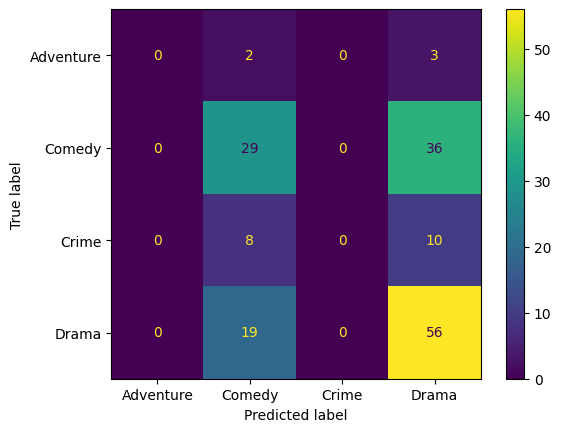

In [13]:
cm = confusion_matrix(y_test_encoded, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.show()

In [14]:
precision = precision_score(y_test_encoded, y_pred_classes, average='weighted')
recall = recall_score(y_test_encoded, y_pred_classes, average='weighted')
f1 = f1_score(y_test_encoded, y_pred_classes, average='weighted')

print(f'Hassasiyet: {precision}')
print(f'Duyarlılık: {recall}')
print(f'F1-Skoru: {f1}')

Hassasiyet: 0.4447852760736196
Duyarlılık: 0.5214723926380368
F1-Skoru: 0.47433787221307794


C:\Users\metin\miniconda3\envs\cv_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
